<a href="https://colab.research.google.com/github/capstone14123412e/Capstone-Project/blob/main/2%2B1dcnnnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

from google.colab import drive
drive.mount('/content/drive')

# Constants
DATASET_PATH = "/content/drive/MyDrive/ActionFinder/UCF50"
IMG_HEIGHT, IMG_WIDTH = 120, 120
FRAMES_PER_VIDEO = 16
NUM_CLASSES = 50  # UCF50 has 50 classes


Mounted at /content/drive


In [ ]:
# Function to load videos and preprocess them
def load_videos(dataset_path):
    videos, labels = [], []
    class_folders = os.listdir(dataset_path)

    for class_index, class_name in enumerate(class_folders):
        class_folder = os.path.join(dataset_path, class_name)
        video_files = os.listdir(class_folder)

        for video_file in video_files:
            video_path = os.path.join(class_folder, video_file)
            cap = cv2.VideoCapture(video_path)
            frames = []

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
                frames.append(frame)

            cap.release()

            # Select a fixed number of frames for each video
            if len(frames) >= FRAMES_PER_VIDEO:
                start = (len(frames) - FRAMES_PER_VIDEO) // 2
                frames = frames[start:start + FRAMES_PER_VIDEO]
                videos.append(np.array(frames))
                labels.append(class_index)

    return np.array(videos), np.array(labels)

# Load videos
videos, labels = load_videos(DATASET_PATH)
labels = to_categorical(labels, num_classes=NUM_CLASSES)


In [ ]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(videos, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Model Definition with 2+1D CNN
model = models.Sequential()

from tensorflow.keras.regularizers import l2

model.add(layers.Conv3D(32, (1, 3, 3), activation='relu', padding='same',
                        input_shape=(FRAMES_PER_VIDEO, IMG_HEIGHT, IMG_WIDTH, 3),
                        kernel_regularizer=l2(0.001)))

model.add(layers.Conv3D(32, (3, 1, 1), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((1, 2, 2)))

model.add(layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same'))
model.add(layers.Conv3D(64, (3, 1, 1), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((1, 2, 2)))

model.add(layers.Conv3D(128, (1, 3, 3), activation='relu', padding='same'))
model.add(layers.Conv3D(128, (3, 1, 1), activation='relu', padding='same'))
model.add(layers.MaxPooling3D((1, 2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Callbacks for saving the model and early stopping
model_save_path = '/content/drive/MyDrive/ActionFinder/UCF50_2plus1D_CNN.keras'
checkpoint = callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Callback: ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by a factor of 0.5
    patience=3,          # Wait for 3 epochs of no improvement
    min_lr=1e-6          # Minimum learning rate
)

# Callback: Save the best model during training
checkpoint = ModelCheckpoint(
    model_save_path,     # Path to save the best model
    save_best_only=True, # Save only when the model improves
    monitor='val_loss',  # Monitor validation loss
    mode='min'           # Save when validation loss is minimized
)

# Train the model with ReduceLROnPlateau
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 70s 390ms/step - accuracy: 0.0889 - loss: 70.1365 - val_accuracy: 0.2050 - val_loss: 2.5551 - learning_rate: 0.0010
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 57s 301ms/step - accuracy: 0.1505 - loss: 2.7618 - val_accuracy: 0.2385 - val_loss: 2.3253 - learning_rate: 0.0010
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 90s 361ms/step - accuracy: 0.2099 - loss: 2.4777 - val_accuracy: 0.3473 - val_loss: 2.0233 - learning_rate: 0.0010
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 344ms/step - accuracy: 0.2775 - loss: 2.2009 - val_accuracy: 0.3766 - val_loss: 1.9120 - learning_rate: 0.0010
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 77s 309ms/step - accuracy: 0.2863 - loss: 2.1620 - val_accuracy: 0.4184 - val_loss: 1.7372 - learning_rate: 0.0010
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 84s 323ms/step - accuracy: 0.3512 - loss: 1.9542 - val_accuracy: 0.4644 - val_loss: 1.7029 - learning_rate: 0.0010
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 87s 360ms/step - accuracy: 0.

In [ ]:
# Validation code
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7816 - loss: 0.7944
Validation Loss: 0.9615, Validation Accuracy: 0.7071


In [ ]:
# Save the final model
model.save(model_save_path)


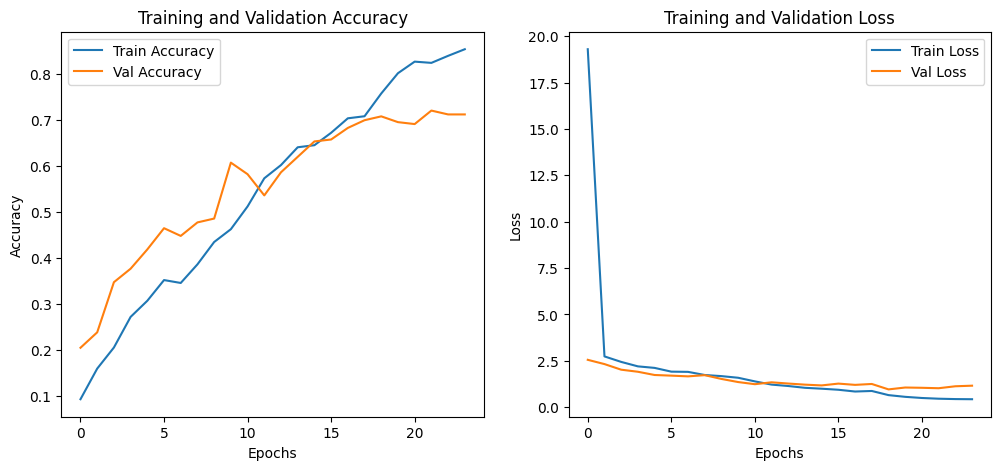

In [ ]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)
